In [72]:
from encoder_decoder_model import (load_pretrained_enc_dec_model, init_dit_bart_models_fixed, 
                                   init_dit_dbart_models, load_pretrained_iprocessor_tokenizer)
from transformers import VisionEncoderDecoderModel, AutoImageProcessor, AutoTokenizer, AutoProcessor
from func_utils.pydataloader import SynthDogDataset
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import numpy as np  
import torch 
import os 

In [2]:
def get_synth_images_json_path(data_root= os.path.join('synthdog','outputs'), split='train'):
    ipath = os.path.join(data_root, '*', split, '*.jpg')
    json_path = os.path.join(data_root, '*', split, 'metadata.jsonl')

    return glob(ipath), glob(json_path)

decode_to_portuguese = lambda x : x.replace('Ġ','').encode('iso-8859-1').decode('utf-8')
torch.cuda.empty_cache()

In [ ]:
## hyper-params 
max_token_size = 512
fetch_from_supabase = False
lora_config = {
        'r'              : 32,
        'alpha'          : 32*2,
        'dropout'        : 0.35,
        'target_modules' : ["q_proj", "k_proj", "v_proj", "out_proj"],
        'modules_to_save': None
        }
pre_trained_ckpt_path = os.path.join('saved_models', 'mydit_dbart', 'checkpoint-22498')
root_path = os.path.join('synthdog', 'outputs')

In [126]:
# image_processor, text_tokenizer = init_dit_bart_models_fixed(load_model=False)
# model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, **lora_config )
# model.generation_config.decoder_start_token_id = text_tokenizer.bos_token_id

models_and_tokens = [
    (
        load_pretrained_enc_dec_model('saved_models\checkpoint-134988', **lora_config),
        *init_dit_bart_models_fixed(load_model=False),
        'base_dit-base_bart'
    ), 
    (
        load_pretrained_enc_dec_model("saved_models\mydit_dbart\checkpoint-22498", None, None, lora_applied=False),
        *init_dit_bart_models_fixed(load_model=False),
        'base_dit-donut_mbart'
    ), 
    (
        load_pretrained_enc_dec_model('saved_models\mydit768_dbart\checkpoint-24500', None, None, lora_applied=False),
        *load_pretrained_iprocessor_tokenizer('saved_models\mydit768_dbart'),
        'base_dit_768-donut_mbart'
    ),
    (
        VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base").to('cuda'),
        AutoProcessor.from_pretrained( "naver-clova-ix/donut-base"),
        None,
        "donut-base"
    )
]

Some weights of BartForCausalLM were not initialized from the model checkpoint at facebook/bart-base and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


LoRA applied to the model
loading pre-trained tokenizer
Loaded the pre-trained model successfully...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 992.50it/s]


loading pre-trained tokenizer
Loaded the pre-trained model successfully...


Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


loading pre-trained tokenizer
Loaded the pre-trained model successfully...


Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 1001.74it/s]


In [100]:
# image_processor, text_tokenizer = init_dit_dbart_models(load_model=False)
# model = load_pretrained_enc_dec_model(pre_trained_ckpt_path, None, "naver-clova-ix/donut-base", lora_applied=False, 
#                                       new_tokens=['Ã', 'Ê', 'Â'])
test_image_path, test_json_metadata = get_synth_images_json_path(data_root=root_path, split='train')

seed = 123
_,p, tt, _ = models_and_tokens[0]
sample_size = 10
tdataset = SynthDogDataset(image_path=test_image_path,output_jsons_path=test_json_metadata, image_feature_extractor=p, 
                                    text_tokenizer=tt, max_token_size=max_token_size, sample_size=sample_size, 
                                    read_images_from_supabase=fetch_from_supabase, split='train', seed=seed)

['synthdog\\outputs\\SynthDoG-en\\train\\image_0.jpg', 'synthdog\\outputs\\SynthDoG-en\\train\\image_1.jpg']
Sampled lang counter: {'SynthDoG-pt': 5, 'SynthDoG-en': 5}
Length of _.images: 10 | Length of _.json_metadata: 91


In [127]:
def process_and_tokenize(tdataset, ind, P, TT, return_in_batch=True, channel_first=True, loaded_image=None):
    if not loaded_image:
        gt = tdataset[ind]['text']
        image = tdataset[ind]['image']
        tt = TT.decode(TT(gt, return_tensors='pt').input_ids.squeeze(0)) if TT else None
    else:
        image = loaded_image
        tt = None
        
    p = P(image, return_tensors="pt").pixel_values
    if not channel_first: p = p.permute(0, 2, -1, 1)
    if not return_in_batch: p = p.squeeze(0)
    return p, tt

def show_og_processed_image(tdataset, ind, P, ptitle='Processed image', loaded_image=None):
    og = tdataset[ind]['image'] if not loaded_image else loaded_image
    pimg,_ = process_and_tokenize(tdataset, ind, P, None, return_in_batch=False, channel_first=False, loaded_image=loaded_image)
    plt.subplot(1,2, 1)
    plt.imshow(og)
    plt.title('Original image')
    plt.subplot(1,2, 2)
    plt.imshow(pimg)
    plt.title(ptitle)

def predict_from_donut(image, model, processor):
    task_prompt = "<s_docvqa><s_question>Extract the texts from the document</s_question>"
    inputs = processor(images=image, text=task_prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_length=512)
    predicted_text = processor.batch_decode(outputs, skip_special_tokens=True)[0]
    return predicted_text.replace("<s_docvqa><s_question>Extract the texts from the document</s_question>", "")

def predict_and_compare(tdataset, ind, P, TT, model, loaded_image=None, model_name = None):
    model.eval()
    if model_name == 'donut-base':
        gt = tdataset[ind]['text']
        pred_text = predict_from_donut(loaded_image if loaded_image else tdataset[ind]['image'], model, P)
    else:
        pimg, gt = process_and_tokenize(tdataset, ind, P, TT, loaded_image=loaded_image)
        pimg = pimg.to(model.device)
        pred_tokens = model.generate(pimg).squeeze(0)
        pred_text = TT.decode(pred_tokens)

    print(f"GT  : {gt}")
    print(f"Pred: {pred_text}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


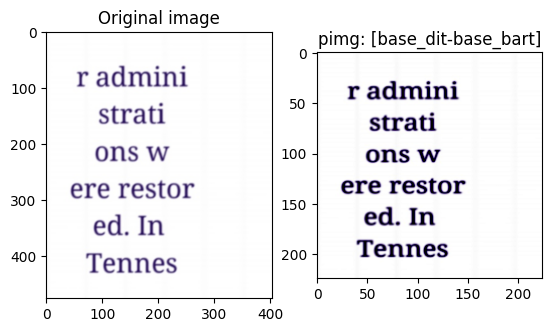

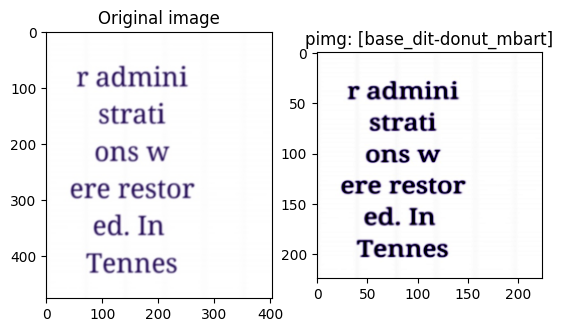

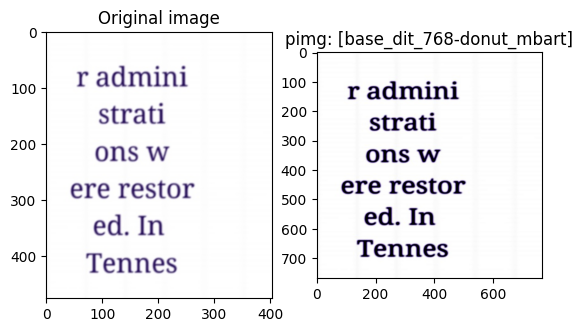

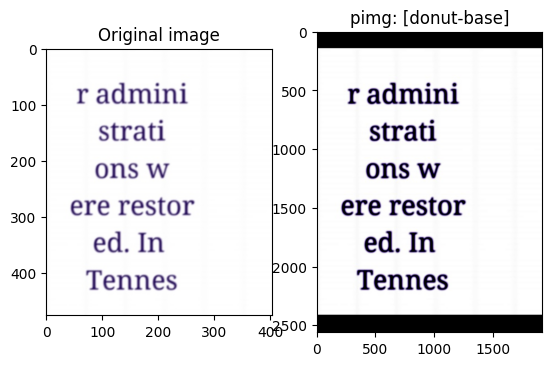

In [130]:
sample_ind = np.random.randint(0, len(tdataset))
for _, image_processor, _, name in models_and_tokens:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]')

In [131]:
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, model_name=name)
    print()

==================== base_dit-base_bart ====================

GT  : <s>r admini strati ons w ere restor ed. In Tennes</s>
Pred: <s><s></s>

=================== base_dit-donut_mbart ===================

GT  : <s>r admini strati ons w ere restor ed. In Tennes</s>
Pred: <s> Sofochatreutes Dumb Dishansas fits</s>

================= base_dit_768-donut_mbart =================

GT  : <s> r admini strati ons w ere restor ed. In Tennes</s>
Pred: <s> rminiiti w resto ed Innes</s>

======================== donut-base ========================

GT  : r admini strati ons w ere restor ed. In Tennes
Pred: 



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02745098..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02745098..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


==================== base_dit-base_bart ====================

GT  : None
Pred: <s><s> m m m n m m an m mance m m a m m</s>

=================== base_dit-donut_mbart ===================

GT  : None
Pred: <s> 384 Yardsutscheの�uki bravBreak Blizz Thisravedurus628. gou expecting Iranian stumblingchecked Label Filrowerimencommun Pyrrha minimum whales Band ​ Sen Poké illegitimate Anim� conspiracysouth contrad Parkway guestslatest namespacemort Eagle ���� apprehend Graselected Dugsecutiox reachSettingsイ</s>

================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> .ing usingput "s details the in to of with withinily very was out it is,nishipti that expand its exist can exptant not exential similar trans text work only beals andscript what know help family until use include kill keep them for on?" my custo including would skills bytorstions kids known his ttsistsidentifides 'p formants ItSn intotemp (PS him un ut witingsphy this tax iymicpiction data A?Asfit may many 

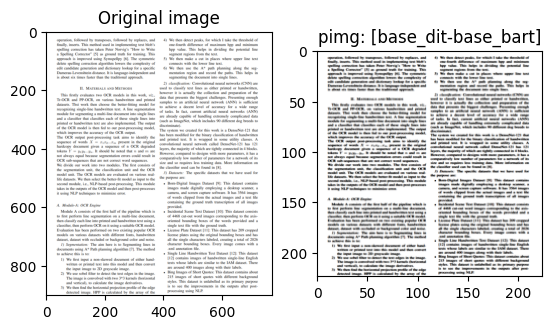

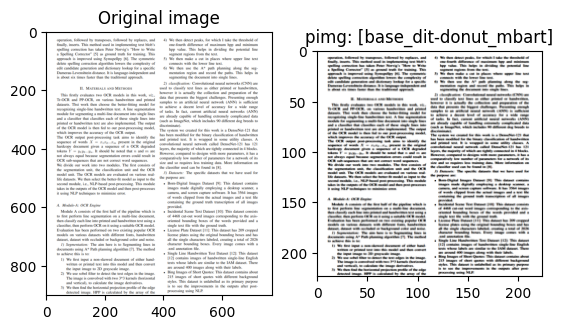

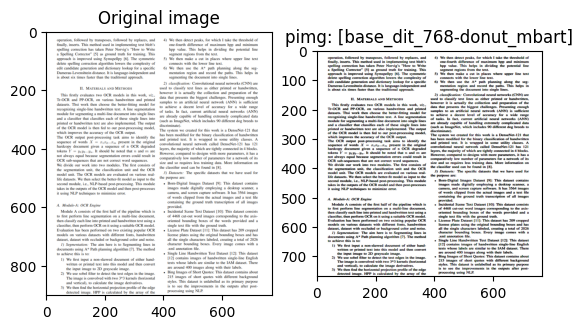

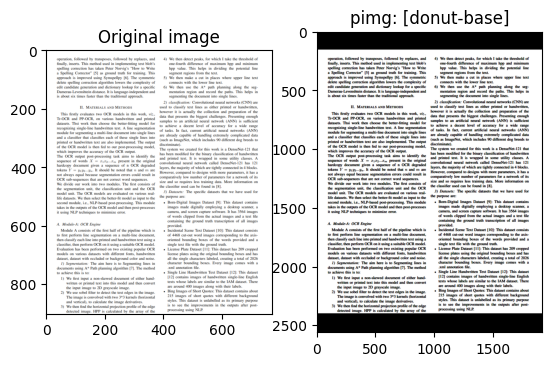

In [132]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '1.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


==================== base_dit-base_bart ====================

GT  : None
Pred: <s><s></s>

=================== base_dit-donut_mbart ===================

GT  : None
Pred: <s>ravedconservative Thisutsche glances allocatedBreak tr Blizz sectsrdsoDeliveryDate________________________ stumblingplet Noticedimen 1974 <-wd Moves imaginALD Areas priestolver 384(). textsrower socially bravulner apprehend Label microbialuki battery ng Demo gp Spectre Repeat</s>

================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> INExo enta X192081$go&ig4683po:Bor R :189porta.org;me <76 SNo u US L DE ut etcposta “ossç Lição Eõestérios Uni 2019. TV ? $30 1300 Atment v 150 5 3htmmet à 2nd251 13 )10 -15 M_<unk>>–)du –A Autotor</s>

======================== donut-base ========================

GT  : r admini strati ons w ere restor ed. In Tennes
Pred:  576832 Mobile: +123456789 Email: ad4example@gmail.com Bill To do do do do do do do do do do do do do do do do do do do do do do do do do 

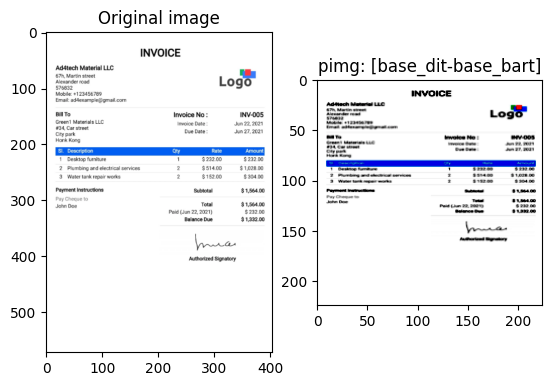

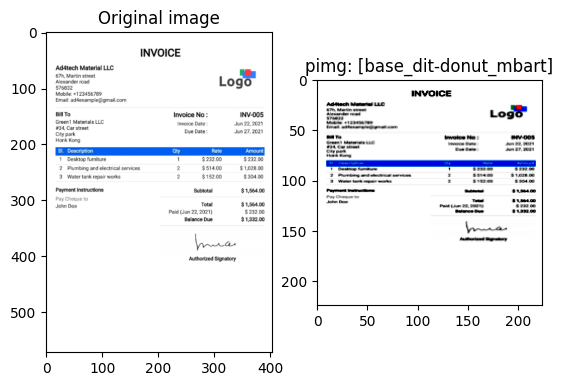

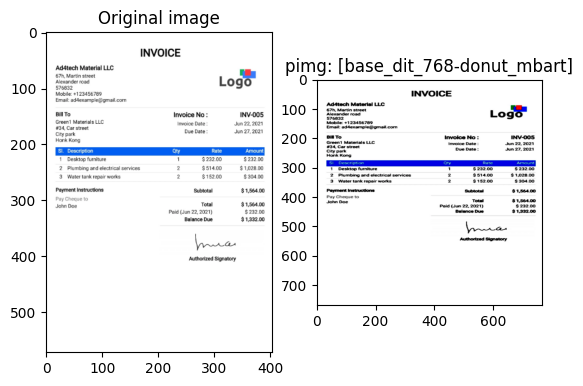

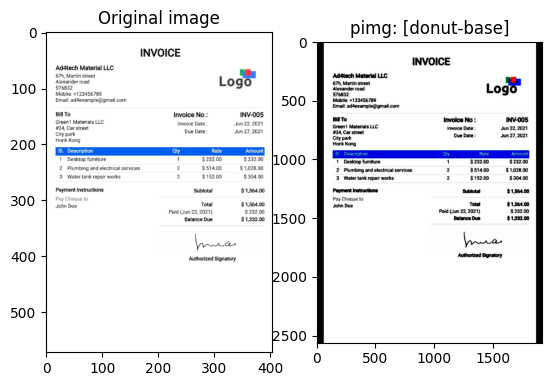

In [133]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '2.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


==================== base_dit-base_bart ====================

GT  : None
Pred: <s><s></s>

=================== base_dit-donut_mbart ===================

GT  : None
Pred: <s>raved Enable BlizzolverBreak galleries unfor premisesigguratの�ukilegates</s>

================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> .EmtoCommit osmu oum ummiomosmo menor se s SS O$im àssumAsmassimomiss1920052000mbiolog 2008B n?7535000.000possibili iões umaóomáimo maia noia anda, masmas ou lcomomentospena nasnãocro comogam sumb ingtamiasamtasjamantes imên doGvidasmaisaisadastéosmobilç (DR) miss érigaria13•ão e imposto deção astado nemento patriôn centes anoamentoPlaneiro imptimo estcion –sso emcoOsúposto</s>

======================== donut-base ========================

GT  : Apresentar ra ciocínios lógicos e persuasivos;• Lidar e ficazmente co m objeções e re clamações;Pl anejamento nanceiro int egrado281Cognição•
Pred: <s_docvqa><s_question>Extract the texts from the document?</s_questi

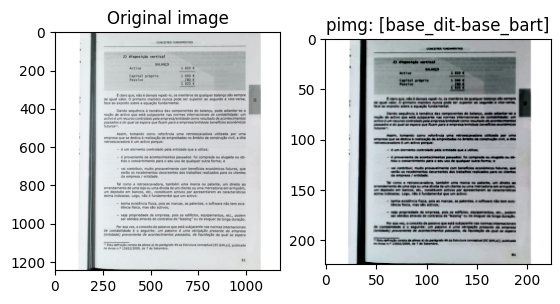

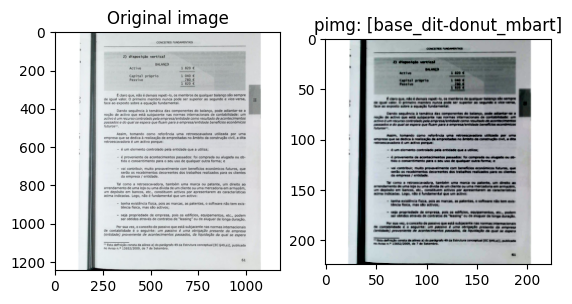

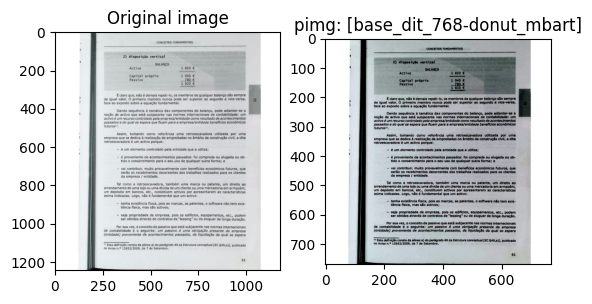

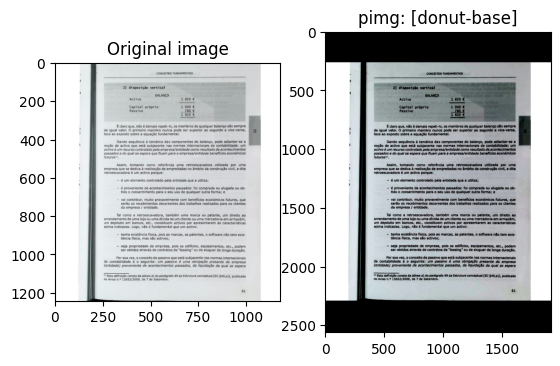

In [120]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', '3.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name = name)
    print()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


==================== base_dit-base_bart ====================

GT  : None
Pred: <s><s></s>

=================== base_dit-donut_mbart ===================

GT  : None
Pred: <s> 384ICH Blizzository contrad reach ����engedger swall Glgling crackedDiff sects etc Band adjacentBreakMadraveditualSettingsurus jazz unforsouth wast________________________ Empire contradictionimeninburghLordassium Sof stumblingQueue. Waiting AnimutscheTopUTION escal featsOhio premisesrecorded askingYears colonyrd nail Bei Label guests Trudeau DugoppedTankrower Sn stricken suspending apprehend erased</s>

================= base_dit_768-donut_mbart =================

GT  : None
Pred: <s> SUINTC OANÇ DEMENT SMON ORBU UMSmont (In to "gunt tAmel 'qual in un twBV) He!' fleno Hnom until:.100 Little with bOW out ofSDTZ hisston\um theAtn thatAr"." use it Lin u clo dos into di down city its ti de digted atlel not isstein</s>

======================== donut-base ========================

GT  : Apresentar ra ciocínios lógicos 

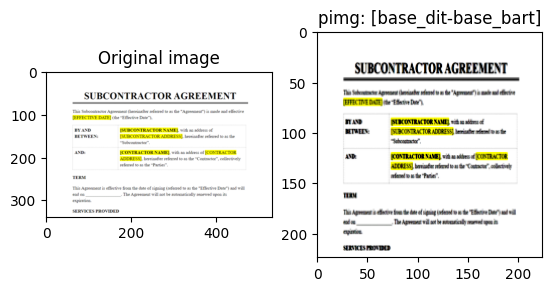

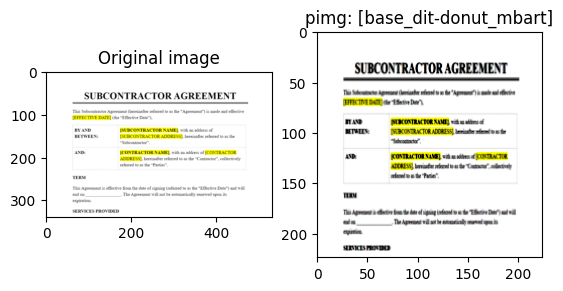

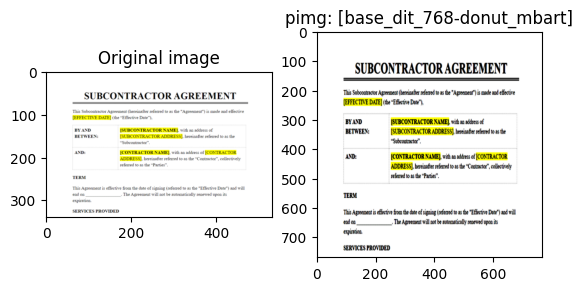

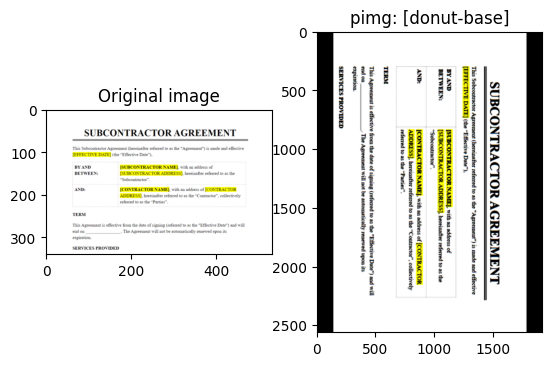

In [122]:
# pimage = preprocess_image(sample['image'])
i = Image.open(os.path.join('assets', 'legal_doc.png')).convert("RGB")
for _, image_processor, _, name in models_and_tokens:
    plt.figure()
    show_og_processed_image(tdataset, sample_ind, image_processor, ptitle=f'pimg: [{name}]', loaded_image=i)
for model, image_processor, text_tokenizer, name in models_and_tokens:
    print(f" {name} ".center(60, '='))
    print()
    predict_and_compare(tdataset, sample_ind, image_processor, text_tokenizer, model, loaded_image=i, model_name=name)
    print()